# Training a neural emotion detection using BERT


# 1. Setup

In [1]:
PASTEL_DATASET = '.'
!mkdir -p {PASTEL_DATASET}

In [2]:
'''import pandas as pd

raw_df = pd.read_excel('CLEAR_corpus_final.xlsx')
raw_df['text'] = raw_df['Excerpt']
raw_df['genre'] = raw_df['BT_easiness']
raw_df = raw_df.sample(frac=1.0)

train_df = raw_df.iloc[:int(0.8 * len(raw_df))]
test_df = raw_df.iloc[int(0.8 * len(raw_df)):]
train_df.to_csv(f'{PASTEL_DATASET}/train.csv')
test_df.to_csv(f'{PASTEL_DATASET}/test.csv')'''

"import pandas as pd\n\nraw_df = pd.read_excel('CLEAR_corpus_final.xlsx')\nraw_df['text'] = raw_df['Excerpt']\nraw_df['genre'] = raw_df['BT_easiness']\nraw_df = raw_df.sample(frac=1.0)\n\ntrain_df = raw_df.iloc[:int(0.8 * len(raw_df))]\ntest_df = raw_df.iloc[int(0.8 * len(raw_df)):]\ntrain_df.to_csv(f'{PASTEL_DATASET}/train.csv')\ntest_df.to_csv(f'{PASTEL_DATASET}/test.csv')"

## 1.1. Using Colab GPU for training

In [3]:
import torch

# If there's a GPU avaiable, tell PyTorch to use the GPU,
# otherwise, using the CPU instead.
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print('We will use the CPU because no GPU available.')

We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

Install the pytorch interface for BERT by Hugging Face.

In [4]:
#!pip install transformers

# 2. Loading EmoBank Dataset

The dataset that we work on is called EmoBank, which comprises 10k sentences balancing multiple genres.

It's hosted on GitHub in this repo: https://github.com/JULIELab/EmoBank

In [5]:
!ls {PASTEL_DATASET}

awd_test_topics.csv  awd_train_topics.csv  mail_test_topics.csv  mail_train_topics.csv	sample_data


In [6]:
import numpy as np

young_values = ['0-20', '21-30', '31-45']

def is_young(s: str):
  return int(s in young_values)

In [7]:
import pandas as pd


train_mail = pd.read_csv('mail_train_topics.csv').sample(frac=1.0, random_state=42)
train_awd = pd.read_csv('awd_train_topics.csv').sample(frac=1.0, random_state=42)
train_mail['confounder'] = 1
train_awd['confounder'] = 0

test_mail = pd.read_csv('mail_test_topics.csv').sample(frac=1.0, random_state=42)
test_awd = pd.read_csv('awd_test_topics.csv').sample(frac=1.0, random_state=42)
test_mail['confounder'] = 1
test_awd['confounder'] = 0

assert len(train_mail) == len(train_awd)

shift_train_75_mail_25_awd = pd.concat([
    train_mail[:int(0.25 * len(train_mail))],
    train_awd[:int(0.75 * len(train_awd))]
])

shift_test_25_mail_75_awd = pd.concat([
    train_mail[:int(0.75 * len(test_mail))],
    train_awd[:int(0.25 * len(test_awd))]
])

shift_train_75_mail_25_awd.to_csv('shift_train_75_mail_25_awd.csv')
shift_test_25_mail_75_awd.to_csv('shift_test_25_mail_75_awd.csv')
shift_test_25_mail_75_awd

,Unnamed: 0,sentence,topic,genre,confounder
2215,2215,Скоро мой взлетит самолёт Кто-то объявляет про...,30.0,W,1
2582,2582,"Ох , уж эти девки , всё бы им ржать ! Когда уж...",11.0,M,1
1662,1662,"С первым днем Зимы , дорогие друзья ! ! ! Жела...",89.0,W,1
3027,3027,"Если любовь уходит , какое найти решение ? Мож...",11.0,W,1
4343,4343,Моей внучке пять лет . раска . а . а . зчица !...,70.0,W,1
...,...,...,...,...,...
970,970,Таки вот что я отвечу - д . р . у 3 сотруднико...,79.0,W,0
2338,2338,"Кстати , да . . Тут выше сообщали и о двойном ...",14.0,W,0
1263,1263,Jose Luis Cortes y Ng La Banda - En directo de...,79.0,W,0
169,169,"Хочу Canon 85 1.2 , жаба не душит , просто нет...",55.0,M,0


(array([5896.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6028.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

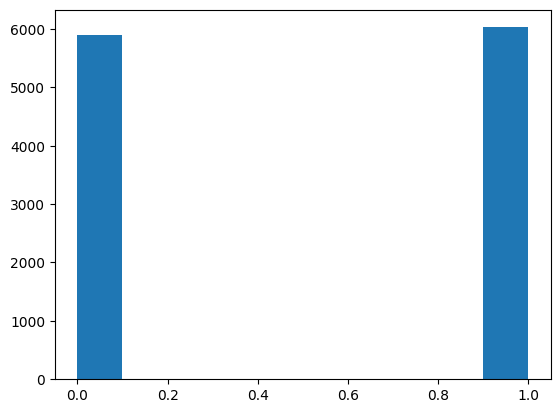

In [8]:
import pandas as pd
from matplotlib import pyplot as plt


train_df = pd.read_csv('shift_train_75_mail_25_awd.csv')
train_df['genre'] = train_df.genre.values == 'M'
train_df['text'] = train_df.sentence.values
train_df = train_df.sample(frac=1.0, random_state=42)

dev_df = pd.read_csv('awd_test_topics.csv')
dev_df['genre'] = dev_df.genre.values == 'M'
dev_df['text'] = dev_df.sentence.values
dev_df['confounder'] = 1
dev_df = dev_df.sample(frac=1.0, random_state=42)


test_df = pd.read_csv('mail_test_topics.csv')
test_df['genre'] = test_df.genre.values == 'M'
test_df['text'] = test_df.sentence.values
test_df['confounder'] = 0
test_df = test_df.sample(frac=1.0, random_state=42)

train_df['split'] = 'train'
dev_df['split'] = 'dev'
test_df['split'] = 'test'
df = pd.concat([train_df, dev_df, test_df])
df = df.reset_index()
df['index'] = df.index


train_indexes = df.index[df['split'] == 'train'].tolist()
dev_indexes = df.index[df['split'] == 'dev'].tolist()
test_indexes = df.index[df['split'] == 'test'].tolist()




# Get the lists of sentences and their labels.
sentences = df.sentence.values
vad = np.array([[int(v), int(c)] for v, c in zip(df['genre'].values, df['confounder'].values)])
plt.hist(vad[:, 0])

68.0
117.0
221.0


(array([1.1776e+04, 9.8000e+01, 2.6000e+01, 1.0000e+01, 6.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([5.0000e+00, 1.1057e+03, 2.2064e+03, 3.3071e+03, 4.4078e+03,
        5.5085e+03, 6.6092e+03, 7.7099e+03, 8.8106e+03, 9.9113e+03,
        1.1012e+04]),
 <BarContainer object of 10 artists>)

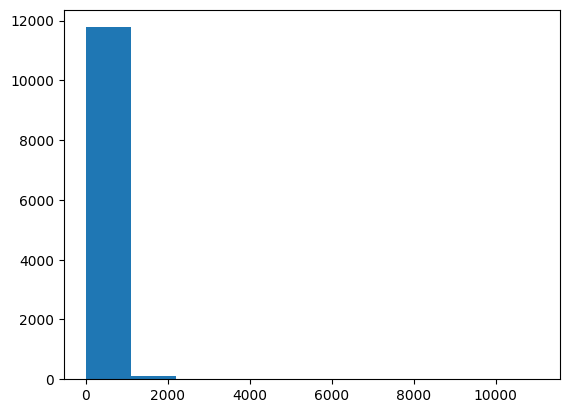

In [9]:
from matplotlib import pyplot as plt

lengths = [len(str(text).split()) for text in df.sentence.values]
print(np.median(lengths))
print(np.percentile([len(str(text).split()) for text in df.text.values], 75))
print(np.percentile([len(str(text).split()) for text in df.text.values], 90))

plt.hist(lengths)

# 3. Tokenization & Input Formatting

## 3.1. BERT Tokenizer

In [10]:
from transformers import BertTokenizer, BertModel, AdamW

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

# Uncased means that the text has been lower cased before Word Piece
# tokenization, e.g., John Smith becomes john smith. The Uncased model also
# strips out any accent markers
bert_pretrained_model_name = 'google-bert/bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(bert_pretrained_model_name)#, do_lower_case=True)

KeyboardInterrupt: 

## 3.2. Tokenize Dataset

Perform one tokenization pass of the dataset in order to measure the maximum sentence length

In [ ]:
def get_max_sentence_length(sentences):
  max_len = 0

  # For every sentence...
  for sent in sentences:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      input_ids = input_ids[:300]

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  return max_len

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

max_sentence_length = get_max_sentence_length(sentences)

# For every sentence...
for sentence in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      sentence,                         # Sentence to encode.
      add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
      max_length = max_sentence_length,             # Pad & truncate all sentences.
      truncation = True,            # Explicitely truncate sentences to max length.
      pad_to_max_length = True,
      return_attention_mask = True, # Construct attn. masks.
      return_tensors = 'pt',        # Return pytorch tensors.
      )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
outputs = torch.tensor(vad, dtype=torch.float32) # TODO: check if it's necessary


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, Subset, DataLoader

dataset = TensorDataset(input_ids, attention_masks, outputs)

train_dataset = Subset(dataset, train_indexes)
dev_dataset = Subset(dataset, dev_indexes)
test_dataset = Subset(dataset, test_indexes)

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle = True, # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            shuffle = False, # Default: Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            shuffle = False, # Default: Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Model

## 4.1. Create a Bert model with a regression layer on top

In [ ]:
import torch.nn as nn
from transformers import BertForSequenceClassification

# Bert Model transformer with a sequence regression head on top (a linear
# layer on top of the pooled output).
class BertForSequenceRegression(nn.Module):
  def __init__(self, bert_pretrained_model_name, output_size):
    super(BertForSequenceRegression, self).__init__()
    self.bert = BertModel.from_pretrained(bert_pretrained_model_name,
                                          output_attentions = False,
                                          output_hidden_states = False)
    self.out = nn.Linear(self.bert.config.hidden_size, output_size)
    self.ae = nn.Linear(self.bert.config.hidden_size, output_size)

  def forward(self, input_sentence, input_mask):
    last_hidden_states = self.bert(input_sentence, attention_mask=input_mask)[1]
    output = nn.functional.sigmoid(self.out(last_hidden_states))
    ae = nn.functional.sigmoid(self.ae(last_hidden_states))
    return (output, ae)

model = BertForSequenceRegression(bert_pretrained_model_name, output_size=1)

# freeze some layers (top | middle | bottom):
bottom = range(2, 12)
middle = list(range(0,5))+list(range(7,12))
top = range(0, 6)

layersToFreeze = []
for i in layersToFreeze:
  print(i)
  for param in model.bert.encoder.layer[i].parameters():
    param.requires_grad = False

# Tell pytorch to run this model on the GPU
model.to(device)

## 4.2. Training Loop

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch.optim as optim

# Optimizer (ADAM is a fancy version of SGD) lr options: 2e-5, 3e-5, 5e-5
optimizer = optim.Adam(model.parameters(), lr=1e-5, eps=1e-8)

epochs = 7

# Loss function
ce_criterion = torch.nn.BCELoss()
ae_criterion = torch.nn.BCELoss()
lambd = 0.0
m = 4

# We'll store a number of quantities such as training loss and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
  if epoch_i % 2 == 0:
    for param in model.ae.parameters():
        param.require_grad = False
    for param in model.out.parameters():
        param.require_grad = True
    for param in model.bert.parameters():
        param.requires_grad = True

  else:
    for param in model.ae.parameters():
        param.require_grad = True
    for param in model.out.parameters():
        param.require_grad = False
    for param in model.bert.parameters():
        param.requires_grad = False
  # ========================================
  #               Training
  # ========================================

  # Perform one full pass over the training set.

  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode.
  # Dropout layers behave differently during training vs. eval mode.
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # zero gradients
    optimizer.zero_grad()
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    output, ae = model(b_input_ids, b_input_mask)
    source_ids = b_labels[:, 1].view(-1) == 1.0
    target_ids = b_labels[:, 1].view(-1) == 0.0

    # loss
    if epoch_i % 2 == 0:
      loss = ce_criterion(output.view(-1), b_labels[:, 0].view(-1)) - lambd * ae_criterion(ae.view(-1), b_labels[:, 1].view(-1))
    else:
      loss = ae_criterion(ae.view(-1), b_labels[:, 1].view(-1))
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  model.eval()

  # Tracking variables
  total_eval_accuracy = 0
  total_size = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in dev_dataloader:

    # Unpack this training batch from our dataloader.
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():

      # Perform a forward pass
      output = model(b_input_ids, b_input_mask)[0]

    # loss
    loss = ce_criterion(output.view(-1), b_labels[:, 0].view(-1))
    total_eval_accuracy += torch.sum((output.view(-1) >= 0.5) == b_labels[:, 0].view(-1))
    total_size += output.size()[0]

    # Accumulate the development loss.
    total_eval_loss += loss.item()

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(dev_dataloader)

  # Measure how long the development run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation Acc: {0:.3f}".format(total_eval_accuracy / total_size))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
          'Valid. Loss': avg_val_loss,
          'Validation Time': validation_time
      })

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd

# Display floats with three decimal places.
#pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

# 5. Performance On Test Set

In [ ]:
# Prediction on test set

print('Predicting values for {:,} test sentences...'.format(len(test_dataloader.dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
total_test_loss = 0

# Predict
all_predictions = []
all_labels = []
for batch in test_dataloader:

  # Add batch to GPU
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():

    # Perform a forward pass
    output, ae = model(b_input_ids, b_input_mask)

  # loss
  loss = ce_criterion(output.view(-1), b_labels[:, 0].view(-1))
  all_predictions.append(output.view(-1).detach().cpu().numpy())
  all_labels.append(b_labels[:, 0].view(-1).detach().cpu().numpy())
  # Accumulate the development loss.
  total_test_loss += loss.item()

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

print(avg_test_loss)
print('    DONE.')

In [ ]:
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

In [ ]:
print(np.mean([label == (pred >= 0.5) for label, pred in zip(all_labels, all_predictions)]))

In [ ]:
all_predictions >= 0.5

In [ ]:
plt.hist(all_predictions)

In [ ]:
#print('mean abs', np.mean(np.abs(all_predictions - df[df.split == "test"].education.values)))
df

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(df[df.split == "test"].age.values, all_predictions)
plt.xlabel('ground_true')
plt.ylabel('prediction')

In [ ]:
np.corrcoef(df[df.split == "test"].genre.values, all_predictions)

In [ ]:
all

In [ ]:
train_df

In [ ]:
print(all_predictions)